In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# read in all the wrods
words = open("makemore/names.txt", "r").read().splitlines()
len(words)

32033

In [3]:
#build the vocabulary of characters and ampping tofrom integers
chars = sorted(list(set("".join(words))))
stoi = {s:i for i,s in enumerate(["."] +chars)}
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi.items())


In [4]:
# shuffle the words
import random
random.seed(42)
random.shuffle(words)

In [5]:
#build the dataset
# build the dataset
def build_dataset(words):
    block_size = 3 # how many chars do we take to predict the next one (context length)
    X, Y = [], []

    for w in words[:]:
        #print(w)
        context = [0]*block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print("".join(itos[i] for i in context),"-->",itos[ix])
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    X.shape, Y.shape
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])



In [6]:
for x,y in zip(Xtr[:20],Ytr[:20]):
    print("".join([itos[ix.item()] for ix in x]),"--->",itos[y.item()])

... ---> e
..e ---> b
.eb ---> r
ebr ---> i
bri ---> m
rim ---> a
ima ---> .
... ---> h
..h ---> i
.hi ---> l
hil ---> t
ilt ---> o
lto ---> n
ton ---> .
... ---> j
..j ---> h
.jh ---> e
jhe ---> n
hen ---> e
ene ---> .


In [26]:
# Let's train and deeper Neural network

class Linear:
    
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in,fan_out)) * 1/(fan_in ** 0.5) #should technically a unifomr dist
        #self.weight = torch.zeros((fan_in,fan_out)) * 1/(fan_in ** 0.5) #change to zero and check how it trains
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias

        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias]) #[] adds nothing which [None] adds a none object
    
class BatchNorm1d:

    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True #pytroch nn modules have this attribute allow us to make hte module have a different behaviour in trianing vs evaluation 
        
        #parameters (trained with backprop)
        #parameters (trained with backprop)
        # restore the representational capacity of hte network that might be lost during
        # the normilization process - gives the network flexibility to learn this
        # which has been shown to improve training dynamic and convergence rates
        
        self.gamma  = torch.ones(dim) #bngain
        self.beta = torch.zeros(dim) #gnbias

        #buffers (trainig ith a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)


    def __call__(self,x):
        #calcualte forward pass
        #want to normalize across the rows of x

        if self.training == True:
            xmean = x.mean(dim = 0, keepdim = True)
            xvar = x.var(dim = 0, keepdim = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        #normalize layer
        xhat =  (x - xmean) / (xvar + self.eps)**0.5 
        self.out = self.gamma * xhat + self.beta

        #update buffers
        if self.training:
            with torch.no_grad(): #context manager for efficiency :)
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar

        #return output
        return self.out #pytorch does not do a self.out - done to allow some inference, just retur d

    def parameters(self):
        return [self.gamma, self.beta]
    


class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX] #indexing into weight matrix :) rather than multiplying
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # get parameters of all layes and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [8]:
torch.manual_seed(42);

In [27]:
n_embd = 10 #embedding dimensions
block_size = 3
n_hidden = 200
g = torch.Generator().manual_seed(2147483547)

model = Sequential([
    Embedding(vocab_size,n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
])

with torch.no_grad():
    #make last layer less confidence
    model.layers[-1].weight *= 0.1

    # #all other layers apply gain of tanh
    # for layer in layers[:-1]:
    #     if isinstance(layer, Linear):
    #         layer.weight *= 5/3 #change this to 1 and then run the activation visualization funciton - CRAZY
    #         #makes so much sense - if linear layers no need out 1/sqrt(n would control)
    #         # but tanh is a squashing funciton so it will decrease the std and thus we need to add a gain to correct for this
    #         # thie gain must be depended on the input being standard normal - as teh amount of sqaushing would depedn on input to tanh
    #         #5/3 is a bit of a magic number hahaha

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


12097


In [30]:
#same optimization as last time....
max_steps = 200000
batch_size = 32
lossi = []
ud = [] #update to data ratio

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g) #random sample of indexes
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward() 

    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().mean() for p in parameters])
    
    # if i > 1000:
    #     break #AFTER_DEBUG obviuoslt take this out


      0/ 200000: 3.2943
  10000/ 200000: 2.2086
  20000/ 200000: 2.7084
  30000/ 200000: 2.4221
  40000/ 200000: 2.2035
  50000/ 200000: 1.9545
  60000/ 200000: 2.2305
  70000/ 200000: 1.7164
  80000/ 200000: 2.4937
  90000/ 200000: 1.7625
 100000/ 200000: 1.9979
 110000/ 200000: 2.2528
 120000/ 200000: 2.2426
 130000/ 200000: 2.2199
 140000/ 200000: 2.1253
 150000/ 200000: 1.8083
 160000/ 200000: 2.4242
 170000/ 200000: 2.3162
 180000/ 200000: 2.1323
 190000/ 200000: 2.1597


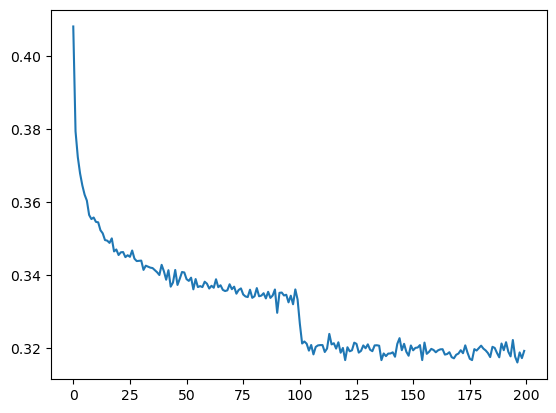

In [32]:
torch.arange(10).view(2,5)
torch.tensor(lossi).view(-1,100).mean(dim = 1).shape #sum every 5 elements
plt.plot(torch.tensor(lossi).view(-1,1000).mean(dim = 1).numpy())

#can see the learning rate decay

In [33]:
# put layers into eval mode (needed for batchnorm expecially)
# not good to call model attributes directly
for layer in model.layers:
    layer.training = False

In [38]:
# evaluate the loss
@torch.no_grad() #thie decorator disables gradient tracking
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte,Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss("train")
split_loss("test")


train 2.065035104751587
test 2.1147289276123047


In [35]:
# sample from hte model

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context])) 
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples = 1).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
          
    print("".join([itos[ix] for ix in out]))


clon.
khristeforrihani.
briyah.
ajulianaisley.
kalie.
anie.
mekaureyani.
khari.
khal.
jeysiah.
logia.
nathan.
kalexa.
mel.
ana.
mal.
paisen.
greste.
brexi.
jadarroni.


# **Network debug**

layer 2 (      Tanh): mean +0.00, std 0.64, saturated 3.20


Text(0.5, 1.0, 'activation distribution')

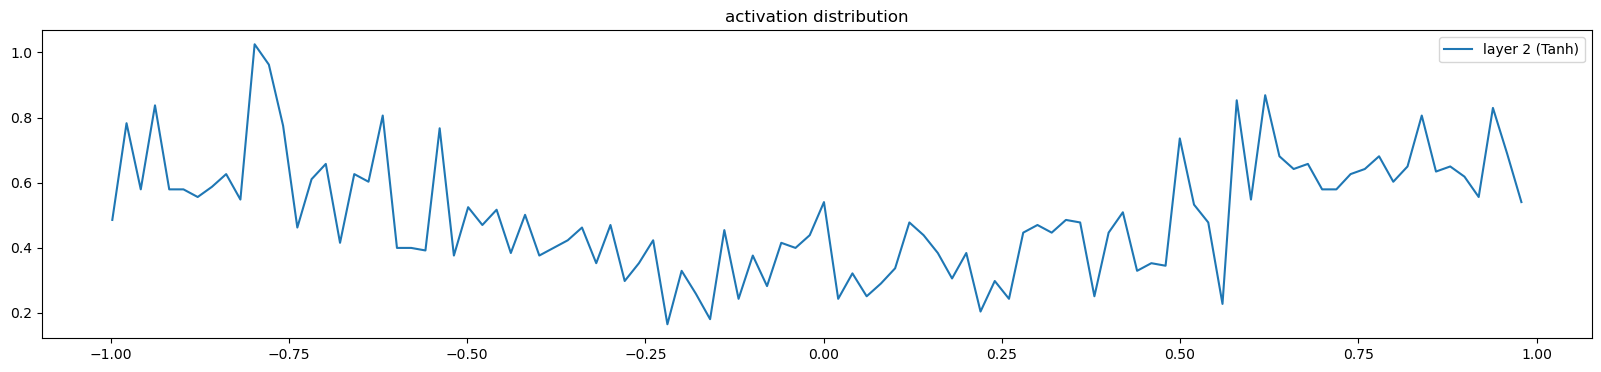

In [28]:
#visualize historgrams of foward pass activations
plt.figure(figsize = (20,4))
legends = []
for i,layer in enumerate(layers[:-1]): #exclude output layer
    if isinstance(layer,Tanh):
        t = layer.out #this is why we need this
        print("layer %d (%10s): mean %+.2f, std %.2f, saturated %.2f" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100 ))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title("activation distribution")

#stabilizes as we add the gain term
# if we do not put it the std shrinks adn the saturation also going to zero

layer 2 (      Tanh): mean -0.000065, std 1.782548e-03


Text(0.5, 1.0, 'gradient distribution')

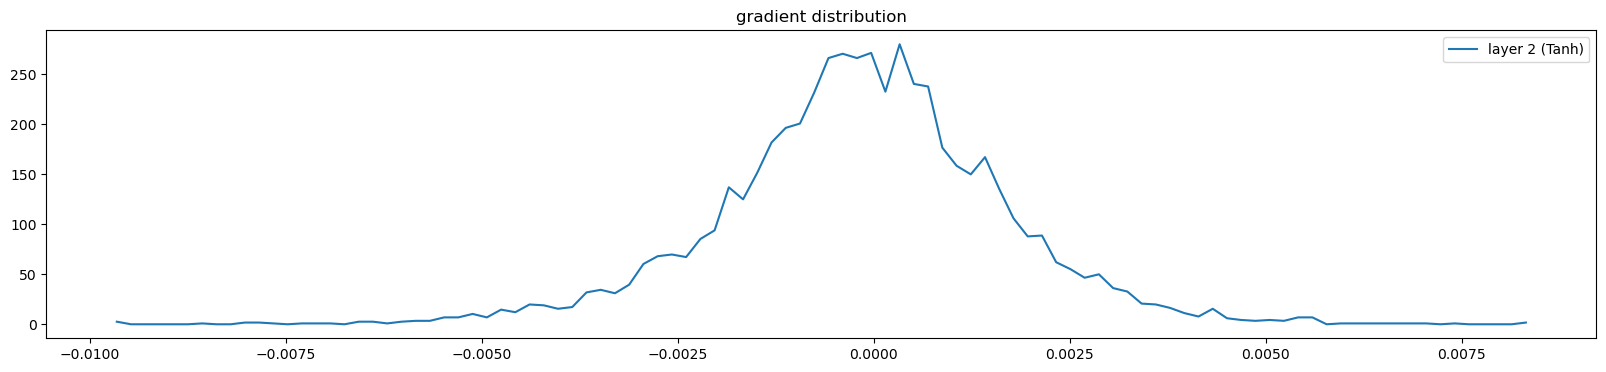

In [29]:
#visualize historgrams of gradients activations
plt.figure(figsize = (20,4))
legends = []
for i,layer in enumerate(layers[:-1]): #exclude output layer
    if isinstance(layer,Tanh):
        t = layer.out.grad #this is why we need this
        print("layer %d (%10s): mean %+f, std %e" % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title("gradient distribution")

#stabilizes as we add the gain term
# if we do not put it the std shrinks adn the saturation also going to zero

weight   (27, 10) | mean -0.000000 | std 9.157771e-03 | grad:data ratio 9.145946e-03
weight  (30, 200) | mean +0.000112 | std 7.799477e-03 | grad:data ratio 4.249698e-02
weight  (200, 27) | mean +0.000000 | std 1.920921e-02 | grad:data ratio 3.622825e-01


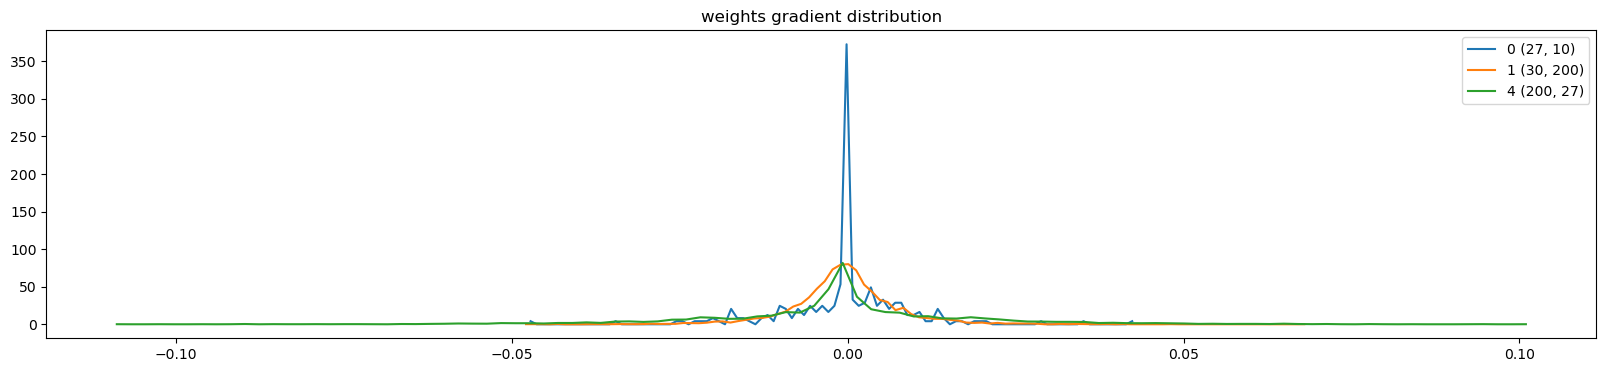

In [30]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad #gradient of the parameters
  p #the parameters themselves
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

# grad:data rtaio
#Size of gradietn compared to size of parameter weights - want to take small steps .data vs .grad
# not true in last layer - whose gradients are 10x greater than all the other weights
# last layers is trained 10x faster
# Fixes itself if you train for a bit longer 

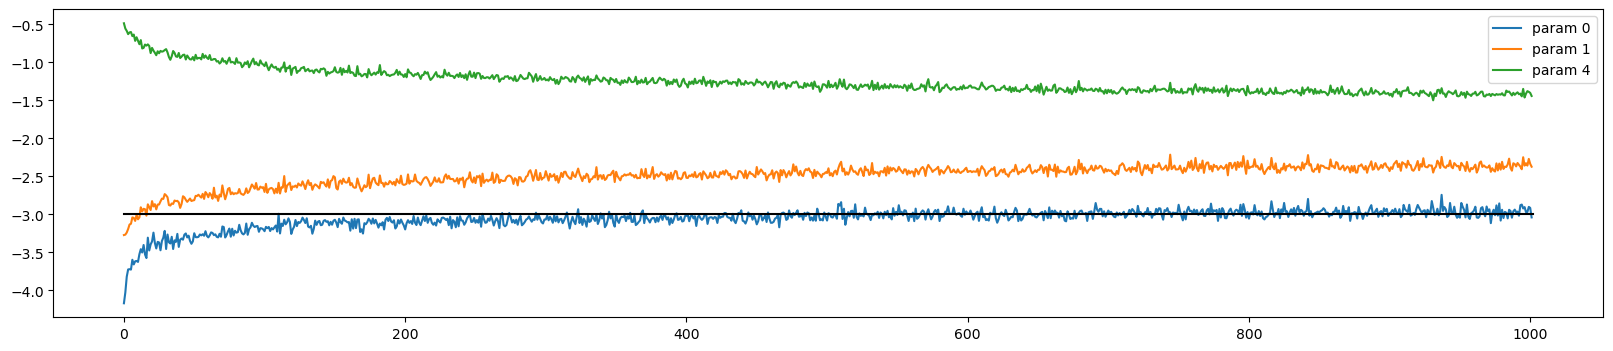

In [31]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

# Problem

We "crush" all of the chs into a single layer at the beginning - even if we make this a bigger layer by adding more neurons - this is still silly

is wavenet chs are crushed slowly

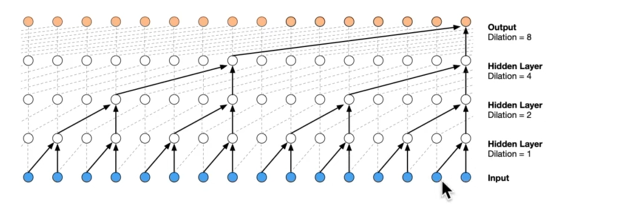

